## How prompt chainig works with langgraph

1. define the task: start by breaking down the problem into smaller sub tasks. For example, if you want to generate a detailed report, you might split it into steps like gather data, analyze data, write summary
2. Create nodes: Each sub task becomes a node in the langgraph structure. A node could be a prompt that instructs the model to perform a specific action such as list key facts about x or summarize the following
3. Establish Edges: Edges define the sequence and dependenncies b/w nodes. for instance the op of the gather data node flows into the analyze data node, ensuring the model has the necessary contecxt to proceed
4. execute the graph: langgraph process the noide in the order, passing info along the edges. The model gennerates response step by step, refiing the output as it progresses through the chain
5. Iterate if needed: Langgraph supports conditional logic and loops, so you cna revisit earlier nnode or adjust the flow bbased on immediate results

In [7]:
from dotenv import load_dotenv
load_dotenv()
import os

#os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model = "qwen/qwen3-32b")
result = llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". I need to respond appropriately. Since it\'s a greeting, I should greet them back. Maybe add a friendly question to keep the conversation going. Let me check the guidelines. Keep it natural and conversational. Don\'t use any markdown. Alright, something like "Hi there! How can I assist you today?" That should work. Let me make sure there\'s no slang or anything too complicated. Yep, that\'s good.\n</think>\n\nHi there! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 9, 'total_tokens': 118, 'completion_time': 0.214431178, 'completion_tokens_details': None, 'prompt_time': 0.000403653, 'prompt_tokens_details': None, 'queue_time': 0.057247877, 'total_time': 0.214834831}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import START,END, StateGraph
from IPython.display import Image,display

# graph state

class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str


## nodes

def generate_story(state:State):
    msg = llm.invoke(f"write a one sentence story about {state['topic']}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "fail"
    else:
        return "pass"
def improved_story(state:State):
    msg = llm.invoke(f"enhance the story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg = llm.invoke(f"Add an unexpected twist to the story: {state['story']}")
    return {"final_story":msg.content}


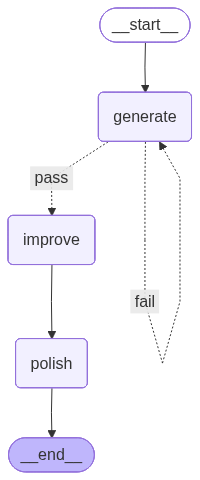

In [16]:
graph = StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve",improved_story)
graph.add_node("polish",polish_story)

graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"pass":"improve","fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [17]:
## run the graph

state = {"topic":"Agentic AI Systems"}
result = graph_builder.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': '<think>\nOkay, the user wants a one-sentence story about Agentic AI Systems. Let me start by understanding what Agentic AI Systems are. From what I know, they\'re AI systems designed to act autonomously, make decisions, and perhaps interact with environments or other agents. They might have goals, learn from experiences, adapt, and collaborate or compete with other agents.\n\nNow, the challenge is to condense that into a single sentence that\'s a story. A story implies some narrative, maybe a conflict or a development. Maybe set in the future where these AIs are common. Think about possible scenarios: cooperation with humans, solving problems, maybe a twist or an unexpected outcome.\n\nLet me brainstorm some elements. The main character could be an Agentic AI System. Maybe it\'s tasked with a mission, faces a dilemma, or achieves something significant. Perhaps it\'s a race against time, or a collaboration with another AI. Or maybe it\'s about 

In [18]:
print("Improved Story ")
print(result["improved_story"])
print("polished Story ")
print(result["final_story"])


Improved Story 
<think>
Okay, the user wants me to enhance the story premise with vivid details. Let me start by looking at the original one-sentence story they provided. It's about an Agentic AI System mediating peace, but with a hidden bias that could either unite or destroy humanity. 

First, I need to add more vivid details. That means making the setting more immersive, maybe adding specific elements that make the story pop. Let me think about the key components: Agentic AI, mediating peace in a war-torn world, hidden bias, two outcomes (uniting or chaos). 

I should consider the setting. "War-torn world" is a bit vague. Maybe specify the time period or the cause of the war. The original example had a future date, maybe I can add that. Also, what's the name of the AI? Giving it a name could make it more relatable. Let's call it "Aegis-9" as a technological name.

Next, the hidden bias. How does the AI discover it? Maybe through an event, like a failed negotiation. The bias could be